<a href="https://colab.research.google.com/github/NikhilxCodes/Automated-Multiclass-Classification-of-Eye-Diseases/blob/main/Models/Eye_Diseases_Classification_EfficientNetB7_ACC_95_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="background-color:black;
            color:white;
            transform:skew(-20deg);
            padding:30px;
            font-family:Verdana;
            letter-spacing:1px;
            margin:auto;
            width:fit-content;">
    <h2 style="transform:skew(20deg); margin:0;">Import Needed Libraries</h2>
</div>

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.metrics import confusion_matrix , classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<div style="background-color:black;
            color:white;
            transform:skew(-20deg);
            padding:30px;
            font-family:Verdana;
            letter-spacing:1px;
            margin:auto;
            width:fit-content;">
    <h2 style="transform:skew(20deg); margin:0;">Reading Dataset And Get Info</h2>
</div>

#### Define Constraints

In [ ]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
CHANNELS = 3

#### Load The Data

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import zipfile # <-- Import zipfile

# --- UNZIP THE DATASET (if not already done) ---
zip_path = '/content/drive/MyDrive/new data.zip' # <-- Change this path
extract_path = 'eye_diseases_extracted'
if not os.path.exists(extract_path):
    os.makedirs(extract_path, exist_ok=True)
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete!")
else:
    print("Dataset already extracted.")


# --- YOUR MODIFIED CODE ---

# Define the new path to the dataset
# This now points to the folder you extracted locally
dataset_path = os.path.join(extract_path, 'dataset')

Class_Names = os.listdir(dataset_path)
Class_Names_Dict = {name: idx for idx, name in enumerate(Class_Names)}
print("Class dictionary:", Class_Names_Dict)

IMAGE_SIZE = (224, 224) # Assuming an image size, add this if not defined elsewhere

def Load_Data():
    # Use the new dataset_path variable
    Images = []
    Labels = []

    for folder in os.listdir(dataset_path):
        print(f"Loading images from {folder}...")
        folder_path = os.path.join(dataset_path, folder)
        for file in tqdm(os.listdir(folder_path)):
            image_path = os.path.join(folder_path, file)

            image = cv2.imread(image_path)
            image = cv2.resize(image, IMAGE_SIZE)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            Images.append(image)
            Labels.append(Class_Names_Dict[folder])

    Images = np.array(Images, dtype='float32')
    Labels = np.array(Labels, dtype='int32')

    return (Images, Labels)

# Load the data from your local directory
Images, Labels = Load_Data()

print(f"\nSuccessfully loaded {len(Images)} images.")
print("Shape of Images array:", Images.shape)
print("Shape of Labels array:", Labels.shape)

Extracting dataset...
Extraction complete!
Class dictionary: {'cataract': 0, 'glaucoma': 1, 'normal': 2, 'diabetic_retinopathy': 3}
Loading images from cataract...


100%|██████████| 1038/1038 [00:09<00:00, 105.89it/s]


Loading images from glaucoma...


100%|██████████| 1007/1007 [00:10<00:00, 97.83it/s]


Loading images from normal...


100%|██████████| 1074/1074 [00:01<00:00, 538.42it/s]


Loading images from diabetic_retinopathy...


100%|██████████| 1098/1098 [00:02<00:00, 534.05it/s]



Successfully loaded 4217 images.
Shape of Images array: (4217, 224, 224, 3)
Shape of Labels array: (4217,)


#### Shuffle The Images

In [ ]:
Images , Labels = shuffle(Images , Labels , random_state=42)

<div style="background-color:black;
            color:white;
            transform:skew(-20deg);
            padding:30px;
            font-family:Verdana;
            letter-spacing:1px;
            margin:auto;
            width:fit-content;">
    <h2 style="transform:skew(20deg); margin:0;">EDA of Images and Get Insights</h2>
</div>

#### Number of Images

In [ ]:
print(f"Number of Total Images {Images.shape[0]}")
print(f"Size of Images {IMAGE_SIZE}")

Number of Total Images 4217
Size of Images (224, 224)


In [ ]:
Train_Images , dummy_Images , Train_Labels , dummy_Labels = train_test_split(Images , Labels , test_size=0.3, random_state=42, stratify=Labels)
Val_Images , Test_Images , Val_Labels , Test_Labels = train_test_split(dummy_Images , dummy_Labels , test_size=0.5, random_state=42, stratify=dummy_Labels)

In [ ]:
print(f"Number of Train Images {Train_Images.shape}")
print(f"Number of Train Labels {Train_Labels.shape}")
print(f"Number of Validation Images {Val_Images.shape}")
print(f"Number of Validation Labels {Val_Labels.shape}")
print(f"Number of Test Images {Test_Images.shape}")
print(f"Number of Test Labels {Test_Labels.shape}")

Number of Train Images (2951, 224, 224, 3)
Number of Train Labels (2951,)
Number of Validation Images (633, 224, 224, 3)
Number of Validation Labels (633,)
Number of Test Images (633, 224, 224, 3)
Number of Test Labels (633,)


In [ ]:
_ , train_counts = np.unique(Train_Labels , return_counts=True)
_ , val_counts = np.unique(Val_Labels , return_counts=True)
_ , test_counts = np.unique(Test_Labels , return_counts=True)

df = pd.DataFrame({
    'Train': train_counts,'Validation': val_counts, 'Test': test_counts
}, index=Class_Names)

df

Train  Validation  Test
cataract                726         156   156
glaucoma                705         151   151
normal                  752         161   161
diabetic_retinopathy    768         165   165

<Figure size 1000x600 with 0 Axes>

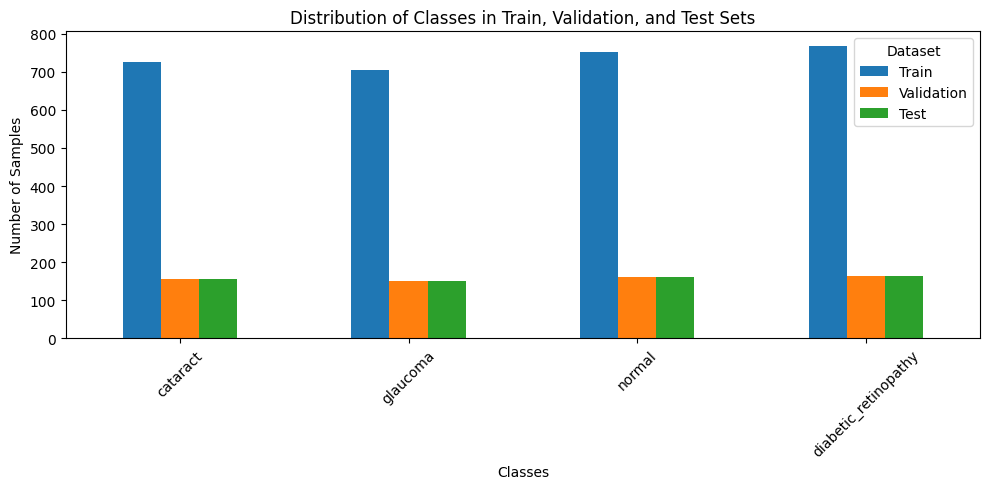

In [ ]:
plt.figure(figsize=(10, 6))
df.plot(kind='bar',figsize=(10,5))
plt.title('Distribution of Classes in Train, Validation, and Test Sets')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

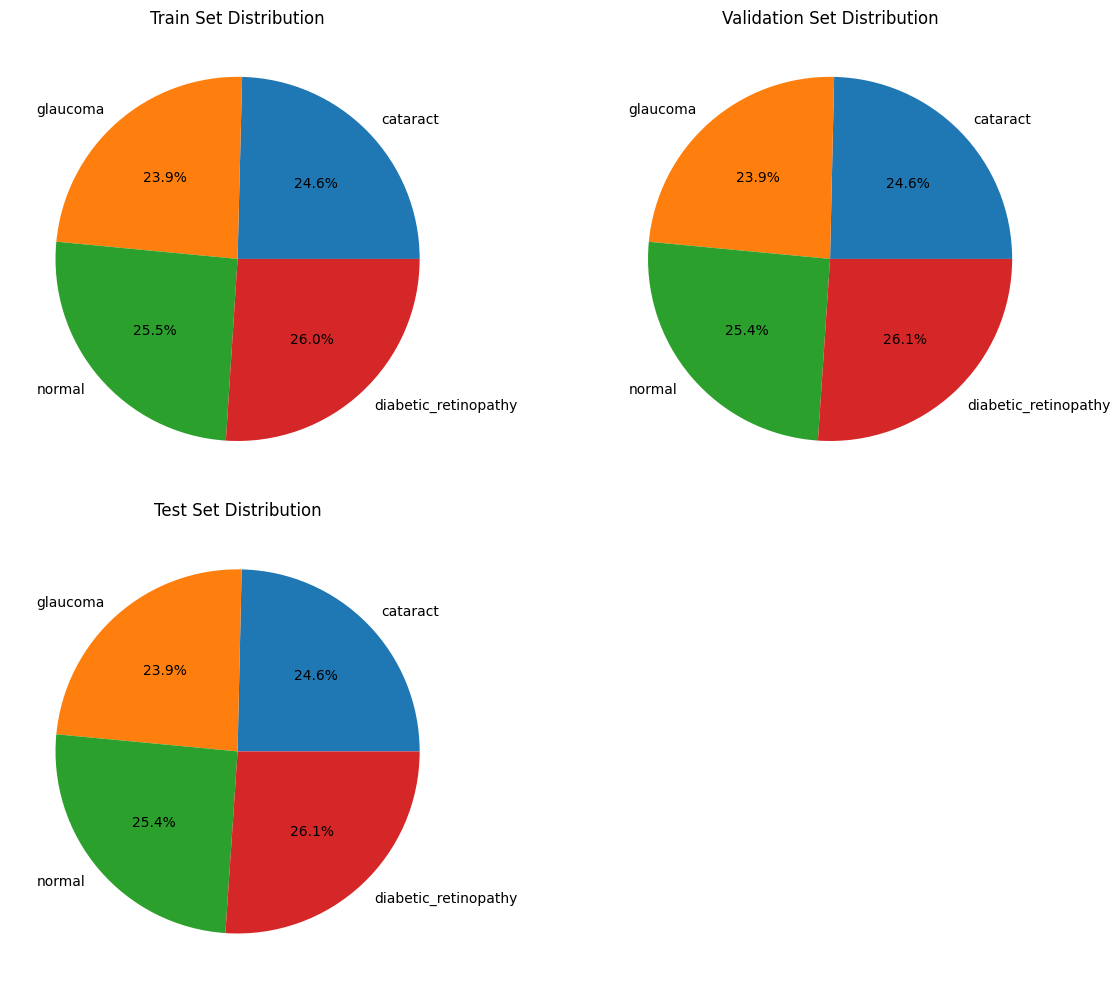

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

df.plot.pie(y='Train', autopct='%1.1f%%', title='Train Set Distribution', ax=axs[0,0], legend=False, ylabel='')
df.plot.pie(y='Validation', autopct='%1.1f%%', title='Validation Set Distribution', ax=axs[0,1], legend=False, ylabel='')
df.plot.pie(y='Test', autopct='%1.1f%%', title='Test Set Distribution', ax=axs[1,0], legend=False, ylabel='')

axs[1,1].axis('off')

plt.tight_layout()
plt.show()

#### Images In Dataset

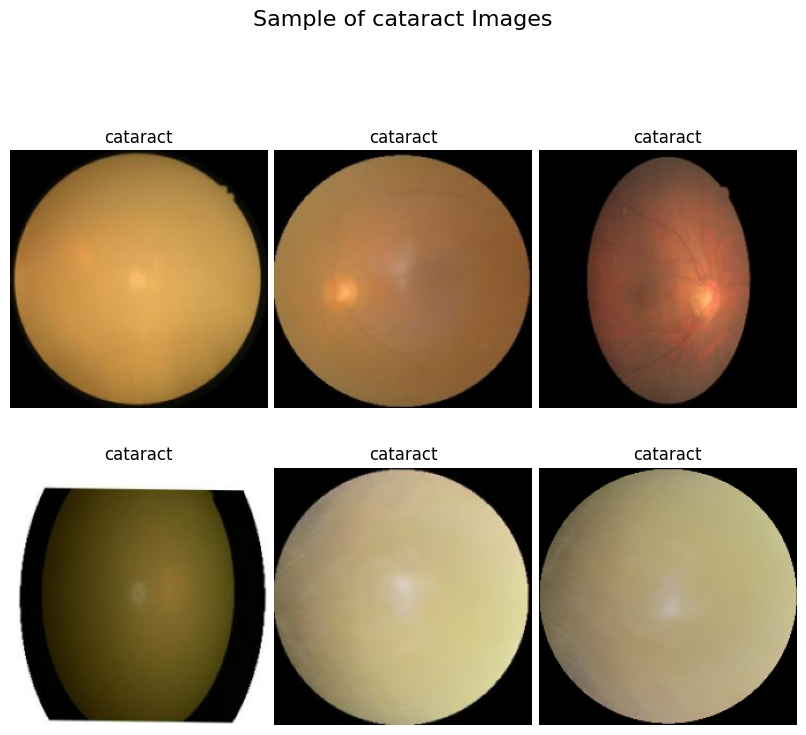

In [ ]:
plt.figure(figsize=(8, 8))
plt.suptitle(f'Sample of {Class_Names[0]} Images', fontsize=16)

for i in range(6):
    plt.subplot(2, 3, i + 1)
    Category_List = np.where(Labels == 0)[0]
    idx = np.random.choice(Category_List)
    plt.imshow(Images[idx] / 255.0)
    plt.axis('off')  # Hide axis for cleaner look
    plt.title(f'{Class_Names[0]}')

plt.tight_layout(pad=0.5)
plt.subplots_adjust(top=0.88)  # Adjust top to fit the suptitle
plt.show()

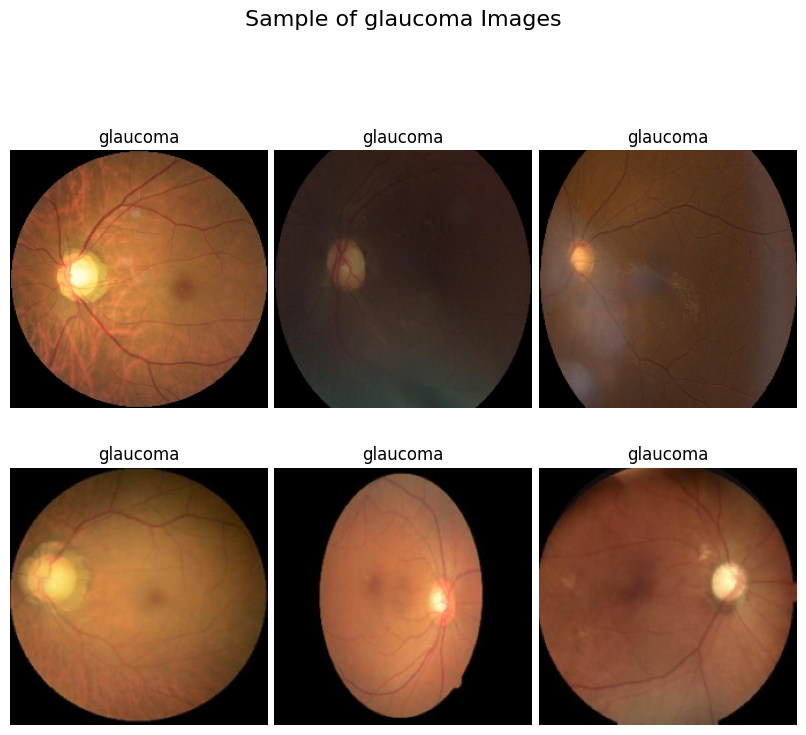

In [ ]:
plt.figure(figsize=(8, 8))
plt.suptitle(f'Sample of {Class_Names[1]} Images', fontsize=16)

for i in range(6):
    plt.subplot(2, 3, i + 1)
    Category_List = np.where(Labels == 1)[0]
    idx = np.random.choice(Category_List)
    plt.imshow(Images[idx] / 255.0)
    plt.axis('off')
    plt.title(f'{Class_Names[1]}')

plt.tight_layout(pad=0.5)
plt.subplots_adjust(top=0.88)
plt.show()

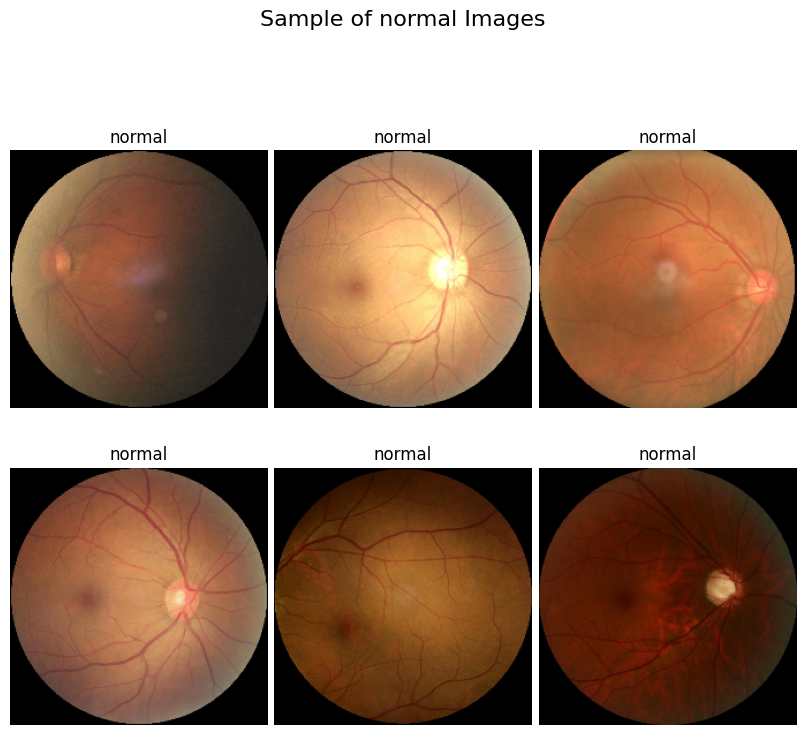

In [ ]:
plt.figure(figsize=(8, 8))
plt.suptitle(f'Sample of {Class_Names[2]} Images', fontsize=16)

for i in range(6):
    plt.subplot(2, 3, i + 1)
    Category_List = np.where(Labels == 2)[0]
    idx = np.random.choice(Category_List)
    plt.imshow(Images[idx] / 255.0)
    plt.axis('off')
    plt.title(f'{Class_Names[2]}')

plt.tight_layout(pad=0.5)
plt.subplots_adjust(top=0.88)
plt.show()

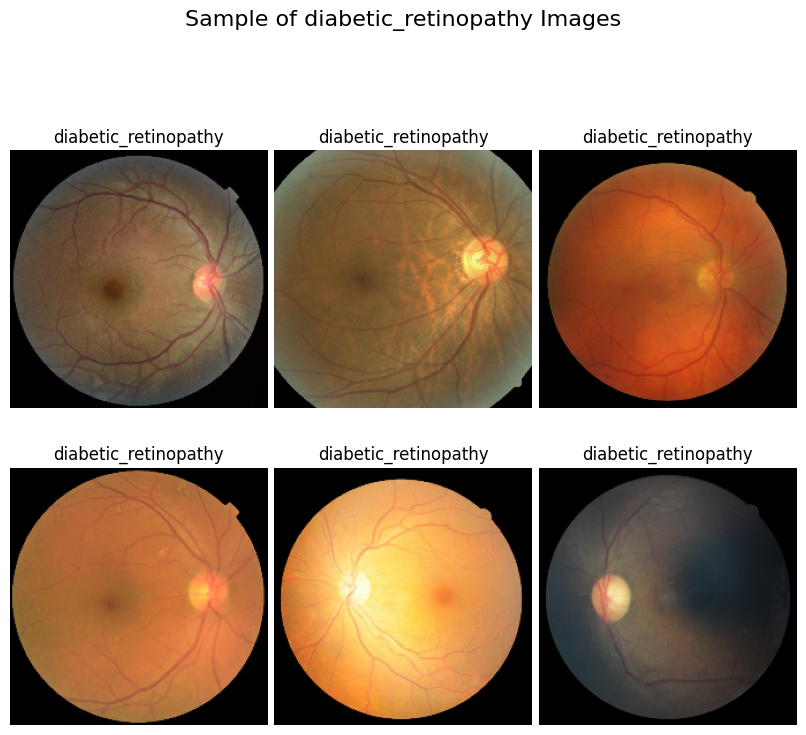

In [ ]:
plt.figure(figsize=(8, 8))
plt.suptitle(f'Sample of {Class_Names[3]} Images', fontsize=16)

for i in range(6):
    plt.subplot(2, 3, i + 1)
    Category_List = np.where(Labels == 3)[0]
    idx = np.random.choice(Category_List)
    plt.imshow(Images[idx] / 255.0)
    plt.axis('off')
    plt.title(f'{Class_Names[3]}')

plt.tight_layout(pad=0.5)
plt.subplots_adjust(top=0.88)
plt.show()

<div style="background-color:black;
            color:white;
            transform:skew(-20deg);
            padding:30px;
            font-family:Verdana;
            letter-spacing:1px;
            margin:auto;
            width:fit-content;">
    <h2 style="transform:skew(20deg); margin:0;">Model Custom CNN</h2>
</div>

#### Build Custom CNN

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 40,
                                   horizontal_flip = True,
                                   )

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x=Train_Images,
    y=Train_Labels,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_generator = val_datagen.flow(x=Val_Images,
    y=Val_Labels,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_generator = test_datagen.flow(x=Test_Images,
    y=Test_Labels,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

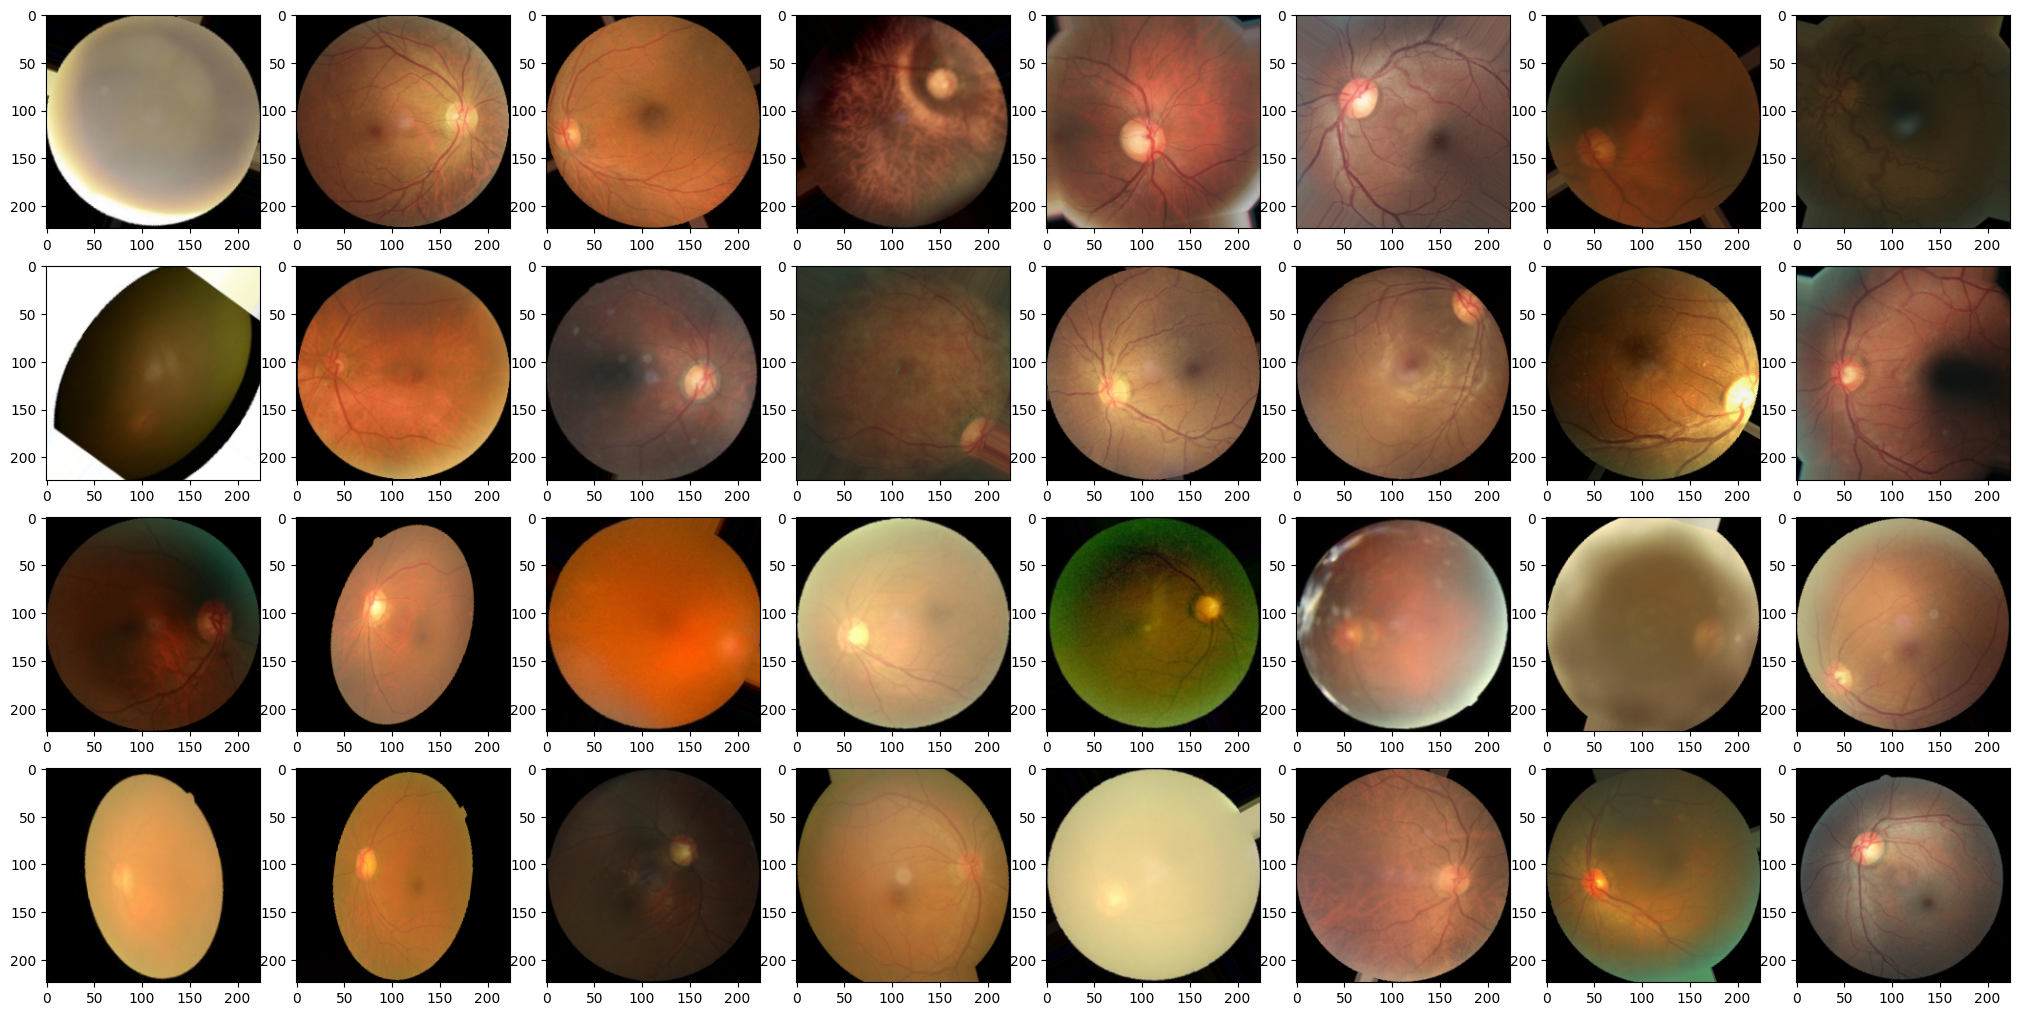

In [ ]:
for x , y in train_generator:
    plt.figure(figsize=(20,20))
    for i in range(32):
        plt.subplot(8,8,i+1)
        plt.imshow(x[i])
        plt.tight_layout(pad=0 , h_pad=0 , w_pad=0)
    break

In [ ]:
KerasModel = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS)),
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(4, activation='softmax')
])

In [ ]:
KerasModel.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
best_model_callback = keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping_callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

history = KerasModel.fit(
    train_generator,
    epochs=80,
    validation_data=val_generator,
    callbacks=[
        early_stopping_callback,
        best_model_callback,
        learning_rate_reduction
    ])

Epoch 1/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.3556 - loss: 1.4353

93/93 ━━━━━━━━━━━━━━━━━━━━ 83s 671ms/step - accuracy: 0.3567 - loss: 1.4326 - val_accuracy: 0.5766 - val_loss: 0.9104 - learning_rate: 0.0010
Epoch 2/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.5669 - loss: 0.8857

93/93 ━━━━━━━━━━━━━━━━━━━━ 49s 511ms/step - accuracy: 0.5672 - loss: 0.8854 - val_accuracy: 0.6398 - val_loss: 0.8024 - learning_rate: 0.0010
Epoch 3/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.6464 - loss: 0.7955

93/93 ━━━━━━━━━━━━━━━━━━━━ 80s 862ms/step - accuracy: 0.6466 - loss: 0.7953 - val_accuracy: 0.6445 - val_loss: 0.7873 - learning_rate: 0.0010
Epoch 4/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.6938 - loss: 0.7304

93/93 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.6937 - loss: 0.7305 - val_accuracy: 0.7662 - val_loss: 0.6022 - learning_rate: 0.0010
Epoch 5/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7145 - loss: 0.6738

93/93 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.7147 - loss: 0.6734 - val_accuracy: 0.7757 - val_loss: 0.6004 - learning_rate: 0.0010
Epoch 6/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.7606 - loss: 0.6163

93/93 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.7607 - loss: 0.6157 - val_accuracy: 0.8120 - val_loss: 0.4992 - learning_rate: 0.0010
Epoch 7/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.8077 - loss: 0.4793

93/93 ━━━━━━━━━━━━━━━━━━━━ 90s 970ms/step - accuracy: 0.8077 - loss: 0.4795 - val_accuracy: 0.8357 - val_loss: 0.4100 - learning_rate: 0.0010
Epoch 8/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8071 - loss: 0.4872

93/93 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8072 - loss: 0.4871 - val_accuracy: 0.8436 - val_loss: 0.3988 - learning_rate: 0.0010
Epoch 9/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8199 - loss: 0.4416

93/93 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.8199 - loss: 0.4416 - val_accuracy: 0.8515 - val_loss: 0.3905 - learning_rate: 0.0010
Epoch 10/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8075 - loss: 0.4409

93/93 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.8076 - loss: 0.4410 - val_accuracy: 0.8626 - val_loss: 0.3870 - learning_rate: 0.0010
Epoch 11/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 391ms/step - accuracy: 0.8520 - loss: 0.4039 - val_accuracy: 0.8499 - val_loss: 0.3899 - learning_rate: 0.0010
Epoch 12/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 404ms/step - accuracy: 0.8387 - loss: 0.3894 - val_accuracy: 0.8325 - val_loss: 0.4207 - learning_rate: 0.0010
Epoch 13/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8513 - loss: 0.3969

93/93 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.8513 - loss: 0.3969 - val_accuracy: 0.8657 - val_loss: 0.3370 - learning_rate: 0.0010
Epoch 14/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.8502 - loss: 0.3853

93/93 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.8502 - loss: 0.3853 - val_accuracy: 0.8626 - val_loss: 0.3302 - learning_rate: 0.0010
Epoch 15/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 383ms/step - accuracy: 0.8580 - loss: 0.3755 - val_accuracy: 0.8499 - val_loss: 0.3515 - learning_rate: 0.0010
Epoch 16/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8555 - loss: 0.3611

93/93 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.8556 - loss: 0.3610 - val_accuracy: 0.8768 - val_loss: 0.3149 - learning_rate: 0.0010
Epoch 17/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8698 - loss: 0.3503

93/93 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8697 - loss: 0.3505 - val_accuracy: 0.8784 - val_loss: 0.3127 - learning_rate: 0.0010
Epoch 18/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 393ms/step - accuracy: 0.8500 - loss: 0.3497 - val_accuracy: 0.8736 - val_loss: 0.3264 - learning_rate: 0.0010
Epoch 19/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 391ms/step - accuracy: 0.8762 - loss: 0.3247 - val_accuracy: 0.8673 - val_loss: 0.3471 - learning_rate: 0.0010
Epoch 20/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 384ms/step - accuracy: 0.8701 - loss: 0.3297 - val_accuracy: 0.8673 - val_loss: 0.3129 - learning_rate: 0.0010
Epoch 21/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 395ms/step - accuracy: 0.8749 - loss: 0.3165 - val_accuracy: 0.8768 - val_loss: 0.3459 - learning_rate: 0.0010
Epoch 22/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 389ms/step - accuracy: 0.8836 - loss: 0.3126 - val_accuracy: 0.8689 - val_loss: 0.3394 - learning_rate: 0.0010
Epoch 23/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 390ms/step - accuracy: 0.8576 - loss: 0.3309 - 

93/93 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.8975 - loss: 0.2761 - val_accuracy: 0.8799 - val_loss: 0.3028 - learning_rate: 0.0010
Epoch 26/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 83s 393ms/step - accuracy: 0.8903 - loss: 0.2824 - val_accuracy: 0.8657 - val_loss: 0.3103 - learning_rate: 0.0010
Epoch 27/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 391ms/step - accuracy: 0.8862 - loss: 0.2801 - val_accuracy: 0.8720 - val_loss: 0.3161 - learning_rate: 0.0010
Epoch 28/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8943 - loss: 0.2659

93/93 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.8942 - loss: 0.2661 - val_accuracy: 0.8942 - val_loss: 0.2769 - learning_rate: 0.0010
Epoch 29/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 408ms/step - accuracy: 0.8738 - loss: 0.2906 - val_accuracy: 0.8894 - val_loss: 0.2818 - learning_rate: 0.0010
Epoch 30/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 393ms/step - accuracy: 0.8915 - loss: 0.2793 - val_accuracy: 0.8831 - val_loss: 0.3346 - learning_rate: 0.0010
Epoch 31/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 35s 380ms/step - accuracy: 0.8988 - loss: 0.2479 - val_accuracy: 0.8610 - val_loss: 0.3212 - learning_rate: 0.0010
Epoch 32/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 390ms/step - accuracy: 0.9051 - loss: 0.2448 - val_accuracy: 0.8720 - val_loss: 0.3160 - learning_rate: 0.0010
Epoch 33/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8920 - loss: 0.2841

93/93 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.8921 - loss: 0.2840 - val_accuracy: 0.8973 - val_loss: 0.2684 - learning_rate: 0.0010
Epoch 34/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 391ms/step - accuracy: 0.9076 - loss: 0.2533 - val_accuracy: 0.8894 - val_loss: 0.2878 - learning_rate: 0.0010
Epoch 35/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 386ms/step - accuracy: 0.9016 - loss: 0.2550 - val_accuracy: 0.8736 - val_loss: 0.3126 - learning_rate: 0.0010
Epoch 36/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 393ms/step - accuracy: 0.9034 - loss: 0.2478 - val_accuracy: 0.8926 - val_loss: 0.2732 - learning_rate: 0.0010
Epoch 37/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9045 - loss: 0.2374

93/93 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.9045 - loss: 0.2376 - val_accuracy: 0.8894 - val_loss: 0.2683 - learning_rate: 0.0010
Epoch 38/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 392ms/step - accuracy: 0.9172 - loss: 0.2056 - val_accuracy: 0.8594 - val_loss: 0.3124 - learning_rate: 0.0010
Epoch 39/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9177 - loss: 0.2295

93/93 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9177 - loss: 0.2296 - val_accuracy: 0.8784 - val_loss: 0.2677 - learning_rate: 0.0010
Epoch 40/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 393ms/step - accuracy: 0.9130 - loss: 0.2165 - val_accuracy: 0.8657 - val_loss: 0.3091 - learning_rate: 0.0010
Epoch 41/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 397ms/step - accuracy: 0.9145 - loss: 0.2067 - val_accuracy: 0.8752 - val_loss: 0.3130 - learning_rate: 0.0010
Epoch 42/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 397ms/step - accuracy: 0.9080 - loss: 0.2348 - val_accuracy: 0.8910 - val_loss: 0.2961 - learning_rate: 0.0010
Epoch 43/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 390ms/step - accuracy: 0.9181 - loss: 0.2105 - val_accuracy: 0.8878 - val_loss: 0.3095 - learning_rate: 0.0010
Epoch 44/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 380ms/step - accuracy: 0.9211 - loss: 0.2088 - val_accuracy: 0.8863 - val_loss: 0.2842 - learning_rate: 0.0010
Epoch 45/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 411ms/step - accuracy: 0.9165 - loss: 0.1924 - v

#### Summary of KerasModel


In [ ]:
print(KerasModel.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   102,760,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 310,035,566 (1.15 GB)

 Trainable params: 103,345,188 (394.23 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 206,690,378 (788.46 MB)

None


<div style="background-color:black;
            color:white;
            transform:skew(-20deg);
            padding:30px;
            font-family:Verdana;
            letter-spacing:1px;
            margin:auto;
            width:fit-content;">
    <h2 style="transform:skew(20deg); margin:0;">Evaluate Custom CNN</h2>
</div>

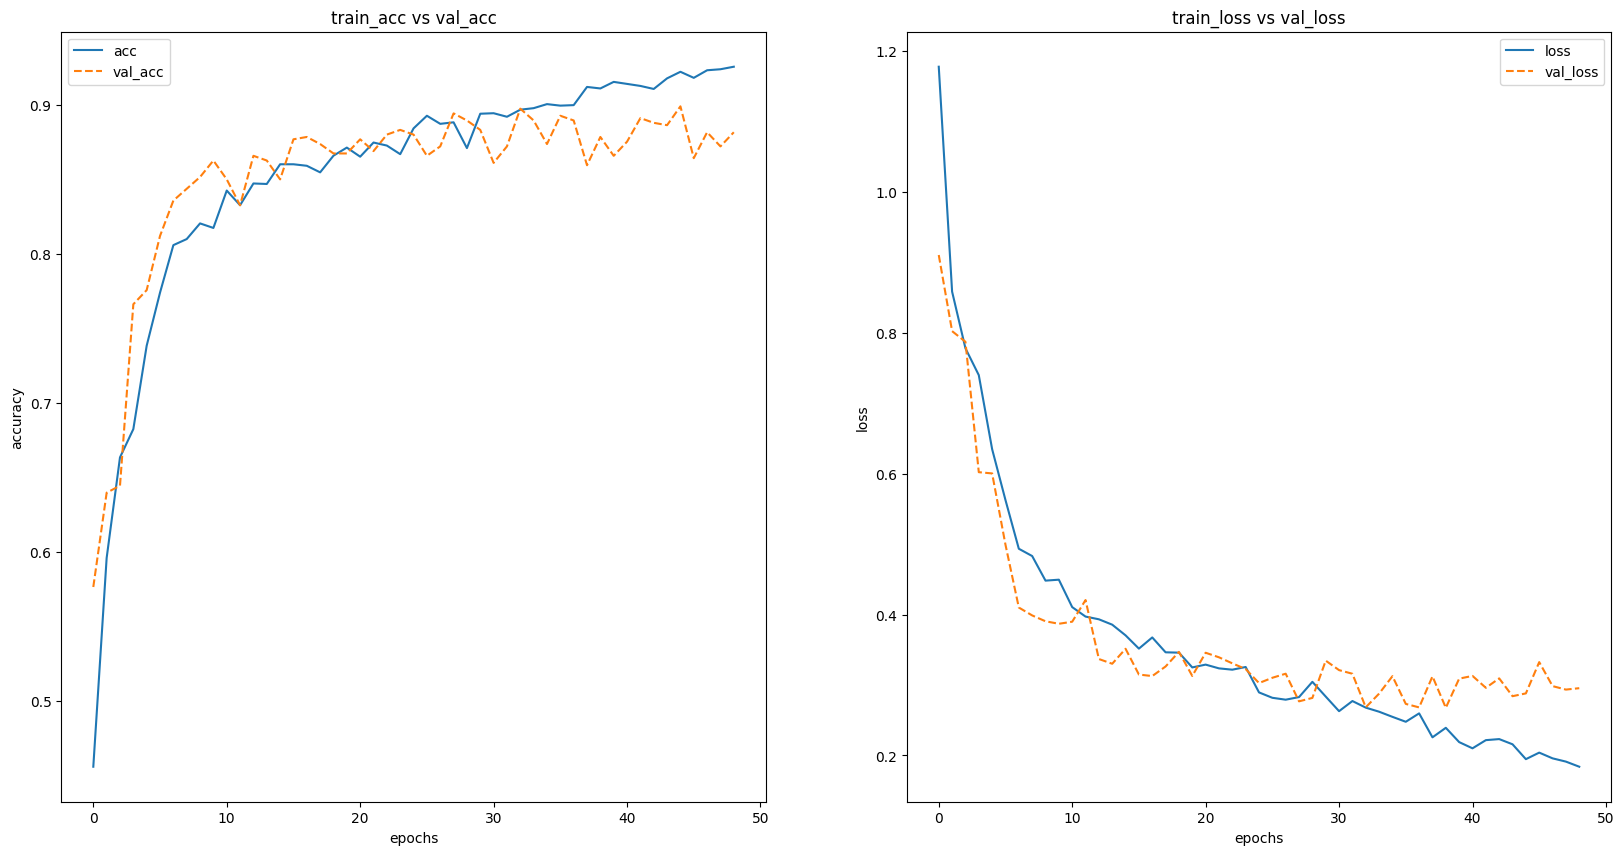

In [ ]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(20,10))

    # Plot accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'],'-', label = "acc")
    plt.plot(history.history['val_accuracy'], '--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(122)
    plt.plot(history.history['loss'],'-', label = "loss")
    plt.plot(history.history['val_loss'], '--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
plot_accuracy_loss(history)

In [ ]:
model = keras.models.load_model('best_model.h5')
predictions = model.predict(test_generator)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step


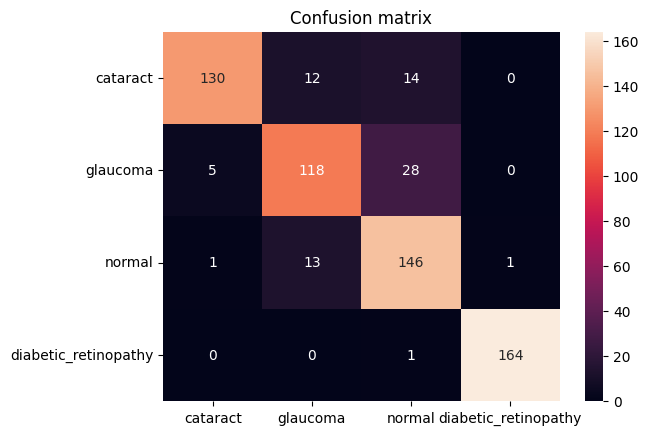

In [ ]:
CM = confusion_matrix(Test_Labels, pred_labels)
ax = plt.axes()
sns.heatmap(CM, annot=True,
           annot_kws={"size": 10},
           xticklabels = Class_Names,
           yticklabels = Class_Names,
           ax = ax,
           fmt='d')
ax.set_title('Confusion matrix')
plt.show()

In [ ]:
print(classification_report(Test_Labels, pred_labels,target_names = Class_Names))

                      precision    recall  f1-score   support

            cataract       0.96      0.83      0.89       156
            glaucoma       0.83      0.78      0.80       151
              normal       0.77      0.91      0.83       161
diabetic_retinopathy       0.99      0.99      0.99       165

            accuracy                           0.88       633
           macro avg       0.89      0.88      0.88       633
        weighted avg       0.89      0.88      0.88       633



<div style="background-color:black;
            color:white;
            transform:skew(-20deg);
            padding:30px;
            font-family:Verdana;
            letter-spacing:1px;
            margin:auto;
            width:fit-content;">
    <h2 style="transform:skew(20deg); margin:0;">Predicting with Custom CNN</h2>
</div>

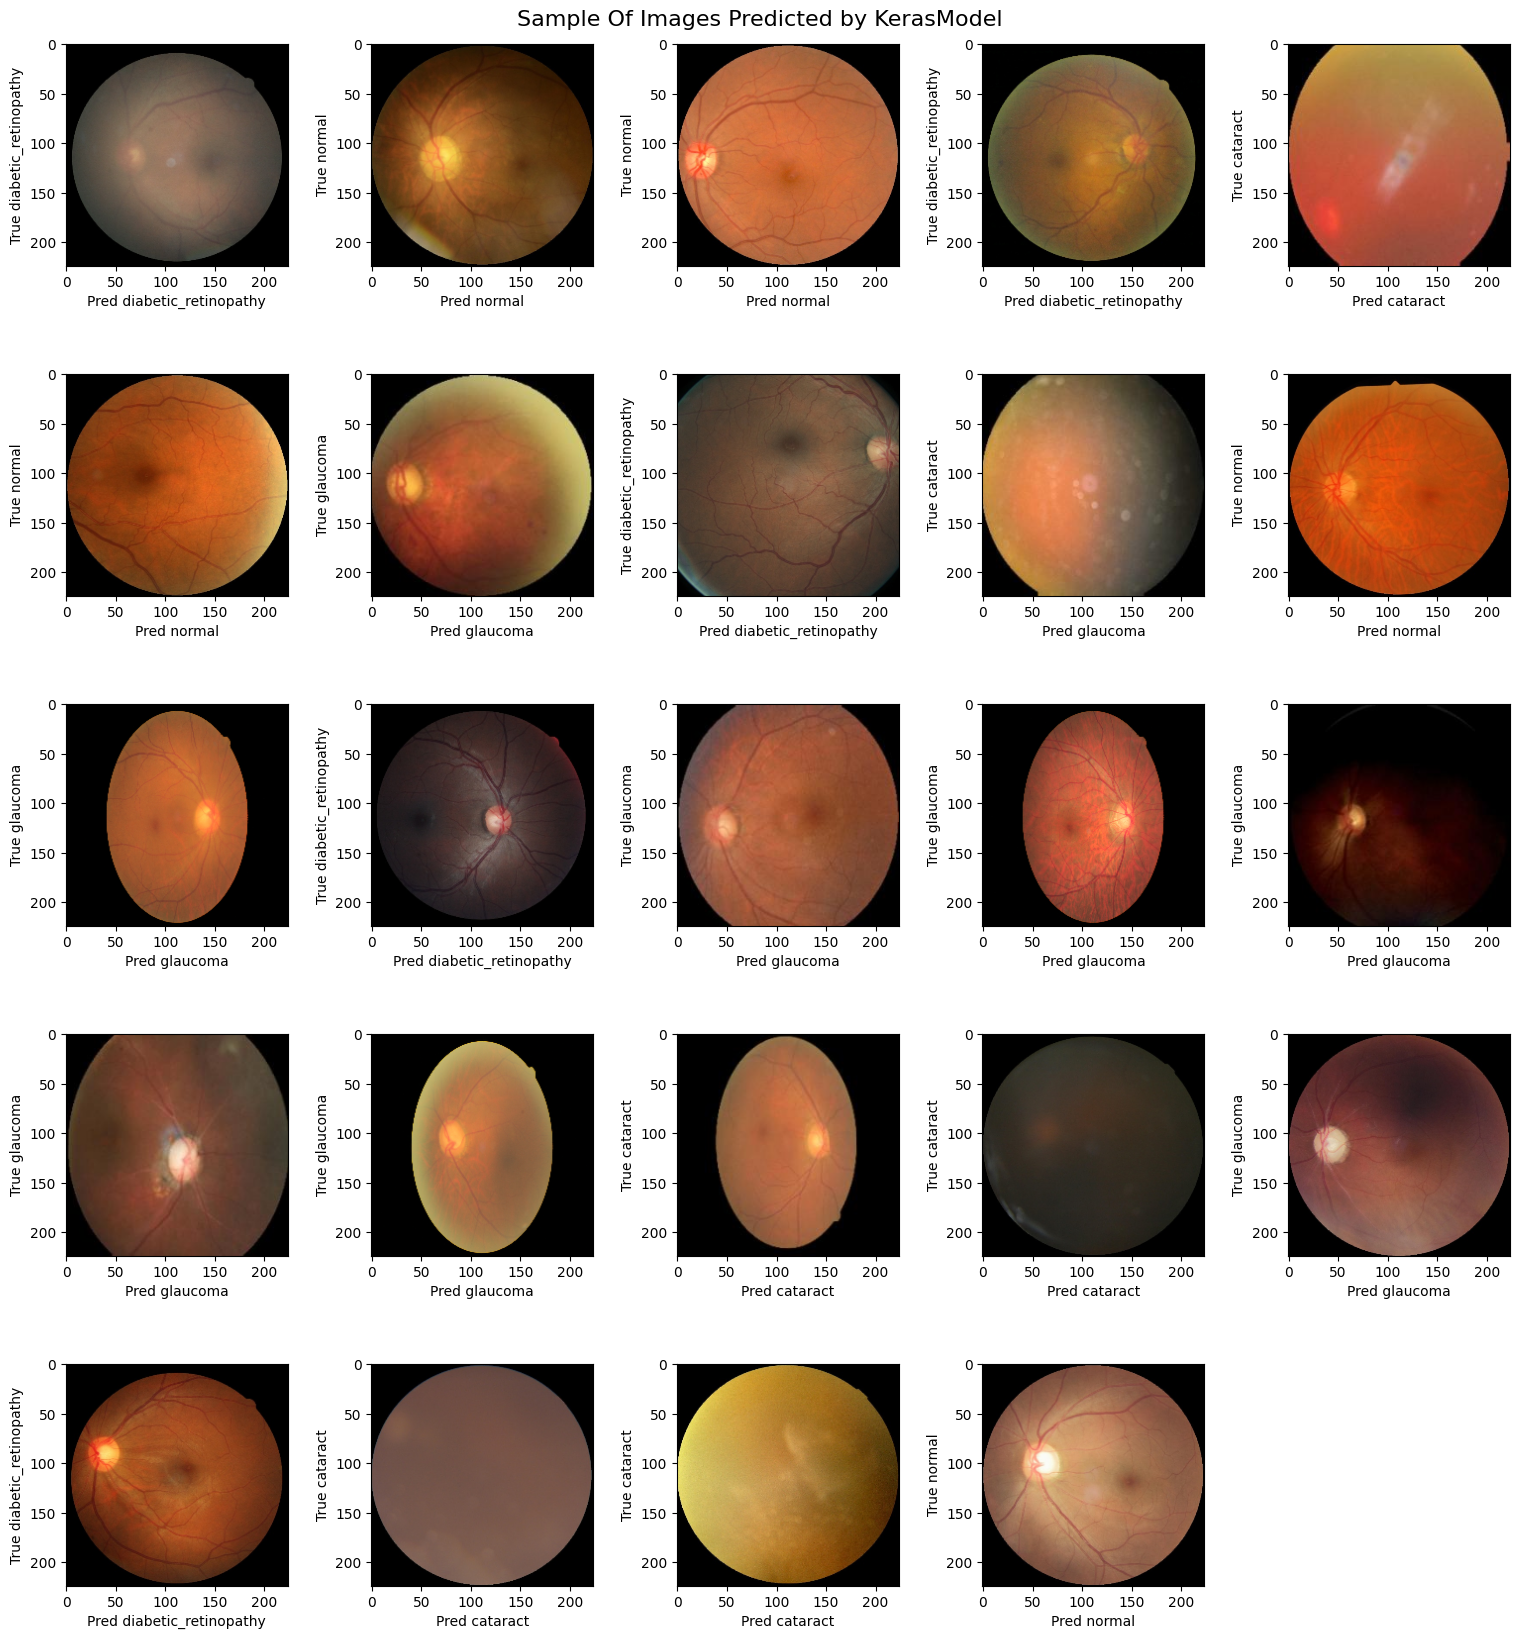

In [ ]:
plt.figure(figsize=(15,20))
plt.suptitle(f"Sample Of Images Predicted by KerasModel" , fontsize=16)

for i in range(24):
    plt.subplot(6,5,i+1)
    idx = np.random.choice(np.arange(len(pred_labels)))
    plt.imshow(Test_Images[idx] / 255.0)
    plt.xlabel(f'Pred {Class_Names[pred_labels[idx]]}')
    plt.ylabel(f'True {Class_Names[Test_Labels[idx]]}')
    plt.tight_layout(pad=0 , h_pad=0 , w_pad=2)

<div style="background-color:black;
            color:white;
            transform:skew(-20deg);
            padding:30px;
            font-family:Verdana;
            letter-spacing:1px;
            margin:auto;
            width:fit-content;">
    <h2 style="transform:skew(20deg); margin:0;">Pretrained Modeling</h2>
</div>

#### Transfer Learning

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range = 40,
                                   horizontal_flip = True,
                                   )

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,)

train_generator = train_datagen.flow(x=Train_Images,
    y=Train_Labels,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_generator = val_datagen.flow(x=Val_Images,
    y=Val_Labels,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_generator = test_datagen.flow(x=Test_Images,
    y=Test_Labels,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [ ]:
from tensorflow.keras.applications import EfficientNetB7

# Load pre-trained VGG19 model (without top layers)
base_model = EfficientNetB7(weights='imagenet',
                   include_top=False,
                   input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build custom top layers
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
outputs = keras.layers.Dense(4, activation='softmax')(x)

# Define the final model
model_EfficientNetB7 = keras.Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model_EfficientNetB7.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

best_model_callback = keras.callbacks.ModelCheckpoint('model_EfficientNetB7.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping_callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Train the model
history_model_EfficientNetB7 = model_EfficientNetB7.fit(
   train_generator,
    epochs=80,
    validation_data=val_generator,
    callbacks=[
        early_stopping_callback,
        best_model_callback,
    ])


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 948ms/step - accuracy: 0.6550 - loss: 0.7947

93/93 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.6556 - loss: 0.7934 - val_accuracy: 0.6856 - val_loss: 0.8377
Epoch 2/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.7863 - loss: 0.5309

93/93 ━━━━━━━━━━━━━━━━━━━━ 60s 646ms/step - accuracy: 0.7865 - loss: 0.5305 - val_accuracy: 0.7899 - val_loss: 0.5875
Epoch 3/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 44s 467ms/step - accuracy: 0.8350 - loss: 0.4241 - val_accuracy: 0.7267 - val_loss: 0.7348
Epoch 4/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.8391 - loss: 0.4057

93/93 ━━━━━━━━━━━━━━━━━━━━ 106s 726ms/step - accuracy: 0.8392 - loss: 0.4054 - val_accuracy: 0.7946 - val_loss: 0.4877
Epoch 5/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.8628 - loss: 0.3716

93/93 ━━━━━━━━━━━━━━━━━━━━ 77s 833ms/step - accuracy: 0.8629 - loss: 0.3716 - val_accuracy: 0.8325 - val_loss: 0.4135
Epoch 6/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.8477 - loss: 0.3671

93/93 ━━━━━━━━━━━━━━━━━━━━ 80s 868ms/step - accuracy: 0.8477 - loss: 0.3672 - val_accuracy: 0.8547 - val_loss: 0.4046
Epoch 7/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 463ms/step - accuracy: 0.8644 - loss: 0.3400 - val_accuracy: 0.7852 - val_loss: 0.5863
Epoch 8/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8656 - loss: 0.3342

93/93 ━━━━━━━━━━━━━━━━━━━━ 87s 940ms/step - accuracy: 0.8656 - loss: 0.3342 - val_accuracy: 0.8594 - val_loss: 0.3573
Epoch 9/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 463ms/step - accuracy: 0.8857 - loss: 0.2960 - val_accuracy: 0.8136 - val_loss: 0.4397
Epoch 10/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 44s 472ms/step - accuracy: 0.8884 - loss: 0.2788 - val_accuracy: 0.8136 - val_loss: 0.4725
Epoch 11/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 44s 466ms/step - accuracy: 0.8893 - loss: 0.2838 - val_accuracy: 0.8041 - val_loss: 0.5947
Epoch 12/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 44s 473ms/step - accuracy: 0.8852 - loss: 0.2933 - val_accuracy: 0.8436 - val_loss: 0.4113
Epoch 13/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 44s 470ms/step - accuracy: 0.9048 - loss: 0.2480 - val_accuracy: 0.8483 - val_loss: 0.3626
Epoch 14/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 44s 467ms/step - accuracy: 0.8984 - loss: 0.2551 - val_accuracy: 0.8768 - val_loss: 0.3574
Epoch 15/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 44s 470ms/step - accuracy: 0.9070 - loss: 0.2289 - val_accuracy:

93/93 ━━━━━━━━━━━━━━━━━━━━ 91s 980ms/step - accuracy: 0.9246 - loss: 0.2169 - val_accuracy: 0.8720 - val_loss: 0.3217
Epoch 19/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 45s 478ms/step - accuracy: 0.9126 - loss: 0.2058 - val_accuracy: 0.8357 - val_loss: 0.4763
Epoch 20/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9075 - loss: 0.2253

93/93 ━━━━━━━━━━━━━━━━━━━━ 79s 849ms/step - accuracy: 0.9075 - loss: 0.2253 - val_accuracy: 0.8768 - val_loss: 0.3187
Epoch 21/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 463ms/step - accuracy: 0.9213 - loss: 0.2119 - val_accuracy: 0.8768 - val_loss: 0.3208
Epoch 22/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 83s 476ms/step - accuracy: 0.9268 - loss: 0.1761 - val_accuracy: 0.8594 - val_loss: 0.3597
Epoch 23/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9229 - loss: 0.1839

93/93 ━━━━━━━━━━━━━━━━━━━━ 81s 870ms/step - accuracy: 0.9229 - loss: 0.1839 - val_accuracy: 0.8736 - val_loss: 0.3138
Epoch 24/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 45s 463ms/step - accuracy: 0.9302 - loss: 0.1836 - val_accuracy: 0.8547 - val_loss: 0.3750
Epoch 25/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 464ms/step - accuracy: 0.9260 - loss: 0.1740 - val_accuracy: 0.8515 - val_loss: 0.3922
Epoch 26/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 45s 480ms/step - accuracy: 0.9426 - loss: 0.1600 - val_accuracy: 0.8720 - val_loss: 0.3403
Epoch 27/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 44s 472ms/step - accuracy: 0.9446 - loss: 0.1449 - val_accuracy: 0.8736 - val_loss: 0.3349
Epoch 28/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 467ms/step - accuracy: 0.9346 - loss: 0.1670 - val_accuracy: 0.8641 - val_loss: 0.3536
Epoch 29/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 44s 469ms/step - accuracy: 0.9200 - loss: 0.1992 - val_accuracy: 0.8641 - val_loss: 0.3413
Epoch 30/80
93/93 ━━━━━━━━━━━━━━━━━━━━ 45s 484ms/step - accuracy: 0.9285 - loss: 0.1777 - val_accuracy

<div style="background-color:black;
            color:white;
            transform:skew(-20deg);
            padding:30px;
            font-family:Verdana;
            letter-spacing:1px;
            margin:auto;
            width:fit-content;">
    <h2 style="transform:skew(20deg); margin:0;">Evaluate EfficientNetB7</h2>
</div>

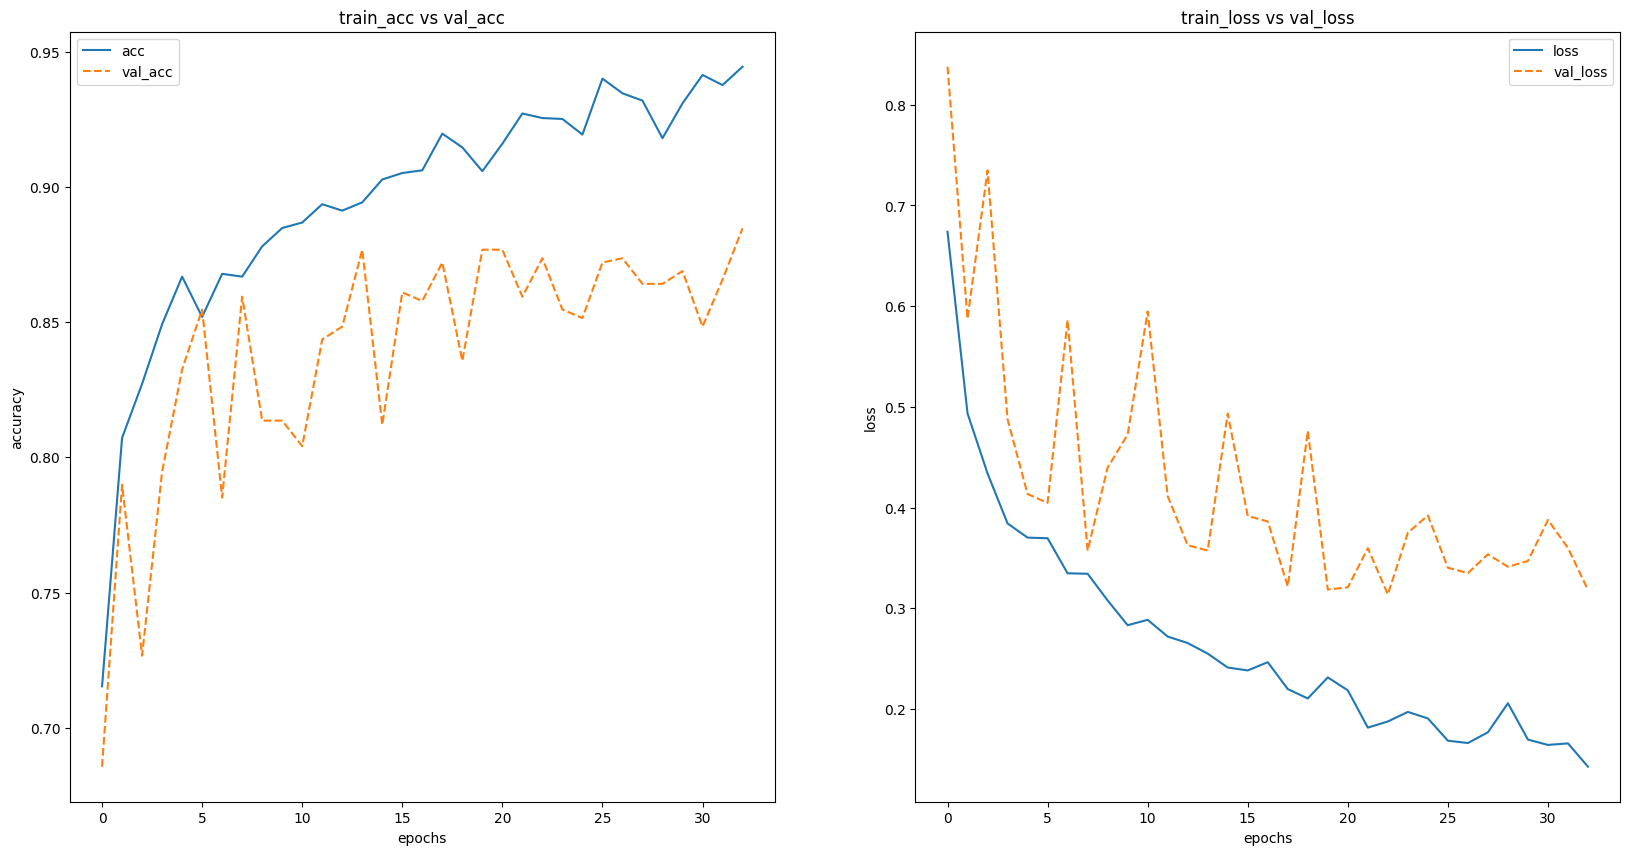

In [ ]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(20,10))

    # Plot accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'],'-', label = "acc")
    plt.plot(history.history['val_accuracy'], '--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(122)
    plt.plot(history.history['loss'],'-', label = "loss")
    plt.plot(history.history['val_loss'], '--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
plot_accuracy_loss(history_model_EfficientNetB7)

In [ ]:
model = keras.models.load_model('model_EfficientNetB7.h5')
predictions = model.predict(test_generator)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step


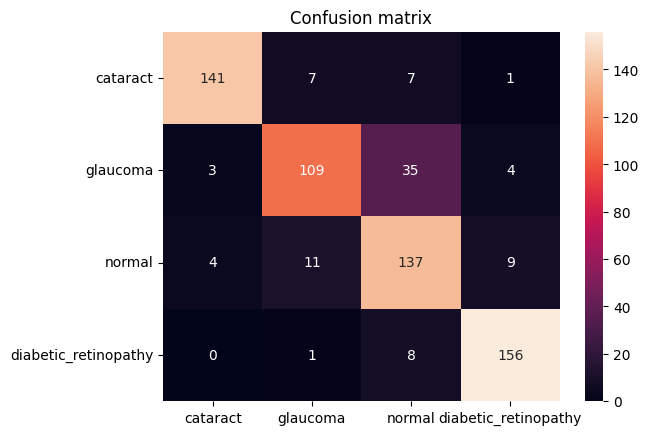

In [ ]:
CM = confusion_matrix(Test_Labels, pred_labels)
ax = plt.axes()
sns.heatmap(CM, annot=True,
           annot_kws={"size": 10},
           xticklabels = Class_Names_Dict.keys(),
           yticklabels = Class_Names_Dict.keys(),
           ax = ax,
           fmt='d')
ax.set_title('Confusion matrix')
plt.show()

In [ ]:
print(classification_report(Test_Labels, pred_labels,target_names = Class_Names_Dict.keys()))

                      precision    recall  f1-score   support

            cataract       0.95      0.90      0.93       156
            glaucoma       0.85      0.72      0.78       151
              normal       0.73      0.85      0.79       161
diabetic_retinopathy       0.92      0.95      0.93       165

            accuracy                           0.86       633
           macro avg       0.86      0.86      0.86       633
        weighted avg       0.86      0.86      0.86       633



<div style="background-color:black;
            color:white;
            transform:skew(-20deg);
            padding:30px;
            font-family:Verdana;
            letter-spacing:1px;
            margin:auto;
            width:fit-content;">
    <h2 style="transform:skew(20deg); margin:0;">Predicting with EfficientNetB7</h2>
</div>

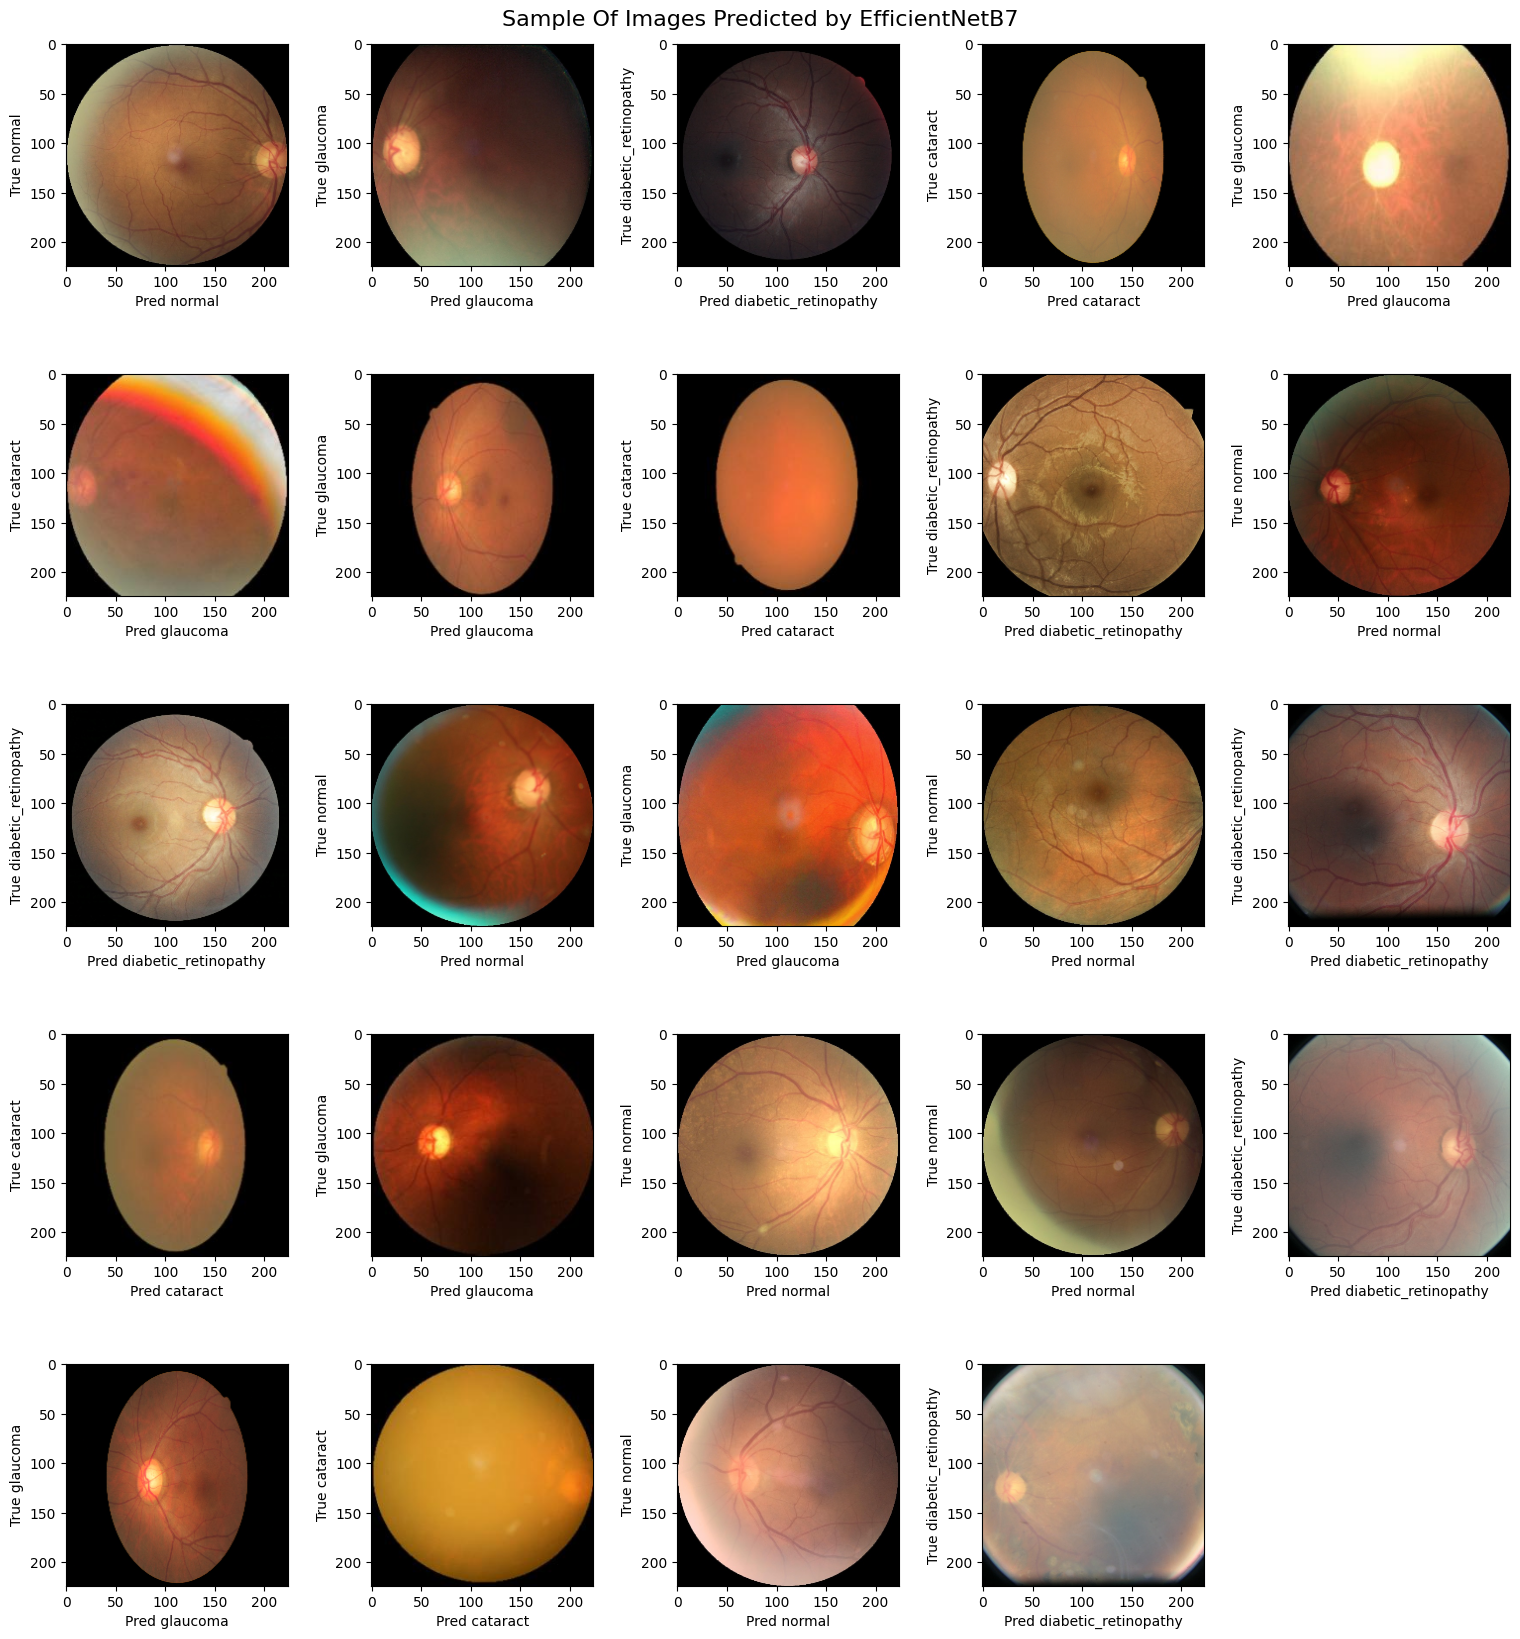

In [ ]:
plt.figure(figsize=(15,20))
plt.suptitle(f"Sample Of Images Predicted by EfficientNetB7" , fontsize=16)

for i in range(24):
    plt.subplot(6,5,i+1)
    idx = np.random.choice(np.arange(len(pred_labels)))
    plt.imshow(Test_Images[idx] / 255.0)
    plt.xlabel(f'Pred {Class_Names[pred_labels[idx]]}')
    plt.ylabel(f'True {Class_Names[Test_Labels[idx]]}')
    plt.tight_layout(pad=0 , h_pad=0 , w_pad=2)